<a href="https://colab.research.google.com/github/ItsShi/Mono-Depth/blob/main/poisson_reconstruction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Installation

!curl -L -s -o SCARED.zip 'https://drive.google.com/uc?id=1LX26iq2qBjvxnbRicXPXidNKclWtQJ2E&confirm=t'

In [ ]:
!pip -q install torchmetrics

     |████████████████████████████████| 512 kB 13.3 MB/s 


#Download Data

In [ ]:
# !pip install -U --no-cache-dir gdown --pre

# import gdown
# url = 'https://drive.google.com/uc?id=1LX26iq2qBjvxnbRicXPXidNKclWtQJ2E'
# gdown.download(url,'SCARED.zip',quiet=True) 
# !unzip -q SCARED.zip 

In [ ]:
depth_targz_drive_path = '/content/drive/MyDrive/SCARED/d3k1_scene_points.tar.gz' # this file is big: about 4G 
depth_unpack_folder = 'd3k1_tiffs'

video_url = 'https://drive.google.com/uc?id=17k1-CHptG_XTXVX8qp7yK_zadH54vVnY'
video_file = 'd3k1.mp4'
video2frame_folder = 'd3k1_frames'

camera_targz_url = 'https://drive.google.com/uc?id=1rrswaVdzir4feGNvDmvW56iql-L0saZL' #'/content/drive/MyDrive/d3k1_frame_data.tar.gz'
camera_pack_file = 'd3k1.tar.gz'
camera_unpack_folder = 'd3k1_jsons'

current_frame = 6

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')
# import tifffile
# import matplotlib.pyplot as plt
# import shutil
# import os
# # if not os.path.exists(camera_unpack_folder):
# shutil.unpack_archive(depth_targz_drive_path, depth_unpack_folder)# takes 1m13s to unpack

# for i in range(3):
#   current_frame = current_frame+(40*i)
#   current_scene = tifffile.imread(os.path.join(depth_unpack_folder, "scene_points%.6d.tiff" % current_frame))[:1024,:,:][:,:,2]
#   plt.subplot(131+i),plt.imshow(current_scene, cmap='gray')

In [ ]:
import cv2
import gdown

gdown.download(video_url, video_file, quiet=True) 
cap = cv2.VideoCapture(video_url) 
n_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))  
fps = cap.get(cv2.CAP_PROP_FPS) 
dur = n_frames / fps 
print("video: {} \nDuration of the video: {} seconds \nNumber of frames: {} \n".format(video_file, dur, n_frames))

video: d3k1.mp4 
Duration of the video: 13.16 seconds 
Number of frames: 329 



In [ ]:
!mkdir d3k1_frames

329


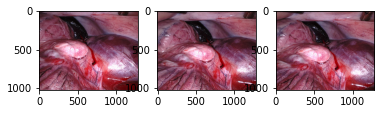

In [ ]:
import matplotlib.pyplot as plt
from glob import glob
import math
import os

capture = cv2.VideoCapture(video_file) 
output_prefix = 'frame_input'
success = True
count = 0
while success:
    success, image = capture.read()
    if success:
        cv2.imwrite(os.path.join(video2frame_folder, "{}{:06d}.jpg".format(output_prefix, count)), image[:1024,:,:], [int(cv2.IMWRITE_JPEG_QUALITY), 100]) #jpg_quality
        count = count + 1  

path_frame_all = glob('d3k1_frames/*.jpg')
print(len(path_frame_all))

for i in range(3):
  plt.subplot(131+i), plt.imshow(plt.imread(os.path.join(video2frame_folder, "{}{:06d}.jpg".format(output_prefix, current_frame+(40*i)))))

In [ ]:
import tarfile
import re
from collections import OrderedDict
from tqdm import tqdm
import json
import numpy as np
import gdown
import shutil
import os

gdown.download(camera_targz_url, camera_pack_file, quiet=True)
poses_list = []
with tarfile.open(camera_pack_file, "r:gz") as frame_data:
  samples = frame_data.getmembers()
  for sample in tqdm(samples, desc="loading pose data", leave=False):
      with frame_data.extractfile(sample) as sample_json:
          pose = np.array(json.loads(sample_json.read())["camera-pose"])
          poses_list.append(pose) 
print(pose, pose.shape)
poses_array = np.array(poses_list)

shutil.unpack_archive(camera_pack_file, camera_unpack_folder)

with open(os.path.join(camera_unpack_folder, "frame_data%.6d.json" % current_frame)) as para_json_file:
  data = json.load(para_json_file)
  print(data.keys(), data['camera-calibration'].keys())  
  print(data['timestamp'])

  camera_pose = data['camera-pose']
  pose = np.array(camera_pose)#(4, 4)
  
  camera_para = data['camera-calibration']
  l_K = np.array(camera_para['KL'])#'KR' camera intrinsic # (3, 3) 
  l_D = np.array(camera_para['DL']) #"DR" distortion coefficient # (1,5)

curr_pose_inv = np.linalg.inv(pose)#(4,4)
print(l_D)# (3, 3)
print(l_K)# (1, 5)

[[ 6.79565802e-01 -7.31499864e-01 -5.56609482e-02 -5.61911743e+00]
 [ 7.32502844e-01  6.80755367e-01 -3.39599501e-03 -3.42786864e-01]
 [ 4.03758211e-02 -3.84639001e-02  9.98443636e-01 -3.27258599e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]] (4, 4)
dict_keys(['camera-calibration', 'camera-pose', 'timestamp']) dict_keys(['DL', 'DR', 'KL', 'KR', 'R', 'T'])
1559265859080344
[[-0.00059516 -0.00054663  0.          0.          0.00182959]]
[[1.03530811e+03 0.00000000e+00 5.96955017e+02]
 [0.00000000e+00 1.03508765e+03 5.20410034e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]


#Prepare Dataloader

total num, train, valid:  329 230 99
torch.Size([3, 256, 320]) torch.Size([256, 320]) tensor(0.) tensor(1.)


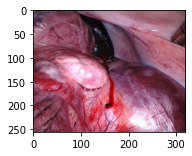

In [ ]:
from glob import glob
from PIL import Image
import numpy as np
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import tifffile
import cv2
import os

os.chdir('/content')
class MyDataset(Dataset):
    def __init__(self, path_depth=None, transform=None):
        self.path_depth = path_depth
        self.transform = transform
        self.len = len(self.path_depth)  

    def __len__(self):
      return len(self.path_depth)   

    def __getitem__(self, i):                                                
        # depth = tifffile.imread(os.path.join(depth_unpack_folder, "scene_points%.6d.tiff" % i))[:1024,:,:][:,:,2]
        # depth = Image.fromarray(depth).convert('L')
        img = Image.open(os.path.join('/content', video2frame_folder, "frame_input%.6d.jpg" % i)).convert('RGB')
        j = i+1
        if j < self.len:
           img1 = Image.open(os.path.join('/content', video2frame_folder, "frame_input%.6d.jpg" % j)).convert('RGB')
        else: img1 = Image.open(os.path.join('/content', video2frame_folder, "frame_input%.6d.jpg" % i)).convert('RGB')
        with open(os.path.join(camera_unpack_folder, "frame_data%.6d.json" % i)) as para_json_file:
          data = json.load(para_json_file)
          camera_pose = data['camera-pose']
          pose = np.array(camera_pose)#(4, 4)          
          camera_para = data['camera-calibration']
          l_K = np.array(camera_para['KL'])#'KR' camera intrinsic # (3, 3) 
          l_D = np.array(camera_para['DL']) #"DR" dist coefficient # (1,5)
        if self.transform:
            img, img1 = self.transform(img), self.transform(img1)
        return img, img1, pose#, l_K, l_D, depth

transform_all = transforms.Compose([
    transforms.Resize((256, 320)),
    transforms.ToTensor(),
])

path_all = glob('d3k1_frames/*.jpg')
path_train = path_all[:230]
path_valid = path_all[230:]
print('total num, train, valid: ', len(path_all), len(path_train), len(path_valid))

dataset_train = MyDataset(path_depth=path_train, transform=transform_all)
dataset_valid = MyDataset(path_depth=path_valid, transform=transform_all)
dataset_all = MyDataset(path_depth=path_all, transform=transform_all)
plt.subplot(121), plt.imshow(dataset_train[220][0].permute(1,2,0))
# plt.subplot(122), plt.imshow(dataset_train[220][1][0], cmap='gray')
# blend = Image.blend(img.convert('RGBA'), depth.convert('RGBA'), 0.5)
print(dataset_train[0][0].shape, dataset_train[0][1][0].shape, dataset_train[0][1].min(), dataset_train[0][1].max())

train_loader = DataLoader(dataset_train, batch_size=20, shuffle=True, num_workers=2)
valid_loader = DataLoader(dataset_valid, batch_size=10, shuffle=False, num_workers=2)
all_loader = DataLoader(dataset_all, batch_size=1, shuffle=False, num_workers=2)

#Arguments

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import os
import sys
import argparse
import numpy as np
import matplotlib.pyplot as plt

def seed_everything(seed=42):
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def get_args():
    parser = argparse.ArgumentParser(description='Kitti Interpolation Training')
    parser.add_argument('--lr', default=1e-3, type=float, help='learning rate')
    parser.add_argument('--batch_size', default=64, type=int, help='batch size')
    parser.add_argument('--valid_batch_size', default=128, type=int, help='batch size')
    parser.add_argument('--max_epochs', default=120, type=int, help='epoch number')
    parser.add_argument('--ckpt', type=str, default='best_model.pth.tar', help='total gpu')
    parser.add_argument('--criterion', type=str, default='bce', help='total gpu')
    parser.add_argument('--frame_ids', type=int, default=[0,1], help='total gpu')

    if 'ipykernel' in sys.modules:
        args = parser.parse_args([])
    else:
        args = parser.parse_args()

    return args

#Initialise pretrained model

In [ ]:
import torch

!git clone https://github.com/nianticlabs/monodepth2.git
#os.chdir('monodepth2')
%cd monodepth2
import networks
from utils import download_model_if_doesnt_exist
model_name = "mono_640x192"
# model_name = "stereo_640x192"
# model_name = 'mono+stereo_640x192'

# model_name = 'mono_1024x320'
# model_name = 'stereo_1024x320'
# model_name = 'mono+stereo_1024x320'

# kitti weights
device = 'cuda' if torch.cuda.is_available() else 'cpu'
download_model_if_doesnt_exist(model_name)
encoder_path = os.path.join("models", model_name, "encoder.pth")
depth_decoder_path = os.path.join("models", model_name, "depth.pth")
pose_encoder_path = os.path.join("models", model_name, "pose_encoder.pth")
pose_decoder_path = os.path.join("models", model_name, "pose.pth")

# LOADING PRETRAINED MODEL
encoder = networks.ResnetEncoder(18, False)
depth_decoder = networks.DepthDecoder(num_ch_enc=encoder.num_ch_enc, scales=range(4))
pose_encoder = networks.ResnetEncoder(18, "pretrained", 2)
pose_decoder = networks.PoseDecoder(encoder.num_ch_enc,1,2)#num_input_features, num_frames_to_predict_for

loaded_dict_enc = torch.load(encoder_path, map_location=device)
filtered_dict_enc = {k: v for k, v in loaded_dict_enc.items() if k in encoder.state_dict()}
# encoder.load_state_dict(filtered_dict_enc)

# loaded_dict = torch.load(depth_decoder_path, map_location=device)
# depth_decoder.load_state_dict(loaded_dict)

loaded_dict = torch.load(pose_encoder_path, map_location=device)
pose_encoder.load_state_dict(loaded_dict)

loaded_dict = torch.load(pose_decoder_path, map_location=device)
pose_decoder.load_state_dict(loaded_dict)

Cloning into 'monodepth2'...
remote: Enumerating objects: 180, done.
remote: Total 180 (delta 0), reused 0 (delta 0), pack-reused 180
Receiving objects: 100% (180/180), 10.27 MiB | 22.66 MiB/s, done.
Resolving deltas: 100% (89/89), done.
/content/monodepth2
-> Downloading pretrained model to models/mono_640x192.zip
   Unzipping model...
   Model unzipped to models/mono_640x192


/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:252: UserWarning: Accessing the model URLs via the internal dictionary of the module is deprecated since 0.13 and may be removed in the future. Please access them via the appropriate Weights Enum instead.
  warnings.warn(
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

<All keys matched successfully>

# test depth and pose
!unzip -q /content/drive/MyDrive/SCARED/ssim_weights.zip

!curl -L -s -o weights 'https://drive.google.com/uc?id=1VYUT2ig1bcL1QsAJ8drkUaDCN0-scxCW'

!pip install --upgrade --no-cache-dir gdown

!pip install -U --no-cache-dir gdown --pre

In [ ]:
# import shutil

# !curl -L -s -o parameters.zip 'https://drive.google.com/uc?id=1VYUT2ig1bcL1QsAJ8drkUaDCN0-scxCW'
# shutil.unpack_archive('/content/parameters.zip', 'parameter')

ReadError: ignored

In [ ]:
# !unzip parameters.zip

Archive:  parameters.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of parameters.zip or
        parameters.zip.zip, and cannot find parameters.zip.ZIP, period.


In [ ]:
os.chdir('/content')
from google.colab import drive
drive.mount('/content/drive')
#scared keyframe weights
# import gdown
# url = 'https://drive.google.com/uc?id=1VYUT2ig1bcL1QsAJ8drkUaDCN0-scxCW'
# gdown.download(url,'weights',quiet=True) 
# unzip -q weights

# shutil.unpack_archive('/content/drive/MyDrive/SCARED/ssim_weights.zip', 'weights')# takes 1m13s to unpack
# training_l = "ssim"
# vali_l = "ssim"
# encoder.load_state_dict(torch.load('/content/weights/weights/encoder_{}.pth'.format( vali_l)))
# depth_decoder.load_state_dict(torch.load('/content/weights/weights/decoder_{}.pth'.format( vali_l)))

encoder.load_state_dict(torch.load("/content/drive/MyDrive/SCARED/encoder_ssim.pth"))
depth_decoder.load_state_dict(torch.load("/content/drive/MyDrive/SCARED/decoder_ssim.pth"))

Mounted at /content/drive


<All keys matched successfully>

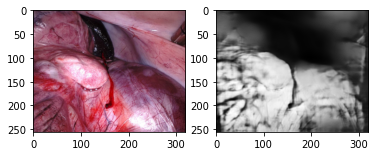

R:
 tensor([[[[-0.0053,  0.0012,  0.0051]],

         [[ 0.0018,  0.0008,  0.0025]]]], grad_fn=<SliceBackward0>)
tensor([[[-0.0053,  0.0012,  0.0051]]], grad_fn=<SelectBackward0>)
tensor([[[ 1.0000, -0.0051,  0.0012,  0.0000],
         [ 0.0051,  1.0000,  0.0053,  0.0000],
         [-0.0012, -0.0053,  1.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  1.0000]]], grad_fn=<CopySlices>)
t:
 tensor([[[[-0.0002,  0.0003, -0.0153]],

         [[-0.0024,  0.0010,  0.0001]]]], grad_fn=<SliceBackward0>)
tensor([[[-0.0002,  0.0003, -0.0153]]], grad_fn=<SelectBackward0>)
tensor([[[ 1.0000e+00,  0.0000e+00,  0.0000e+00, -1.7476e-04],
         [ 0.0000e+00,  1.0000e+00,  0.0000e+00,  3.2318e-04],
         [ 0.0000e+00,  0.0000e+00,  1.0000e+00, -1.5258e-02],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]]],
       grad_fn=<CopySlices>)
M:  tensor([[[ 9.9999e-01, -5.0836e-03,  1.1649e-03, -1.7476e-04],
         [ 5.0774e-03,  9.9997e-01,  5.2909e-03,  3.2318e-04],
         [-1.19

In [ ]:
os.chdir('/content')
inputs = {}
inputs[("color", 0, 0)] = dataset_train[220][0]
inputs[("color", 1, 0)] = dataset_train[221][0]

# depth
feat = encoder(inputs[("color", 0, 0)][None])
pred = depth_decoder(feat)
plt.subplot(121), plt.imshow(dataset_train[220][0].permute(1,2,0))
# plt.subplot(132), plt.imshow(dataset_train[220][1][0], cmap='gray')
plt.subplot(122), plt.imshow(pred[('disp',0)][0][0].detach().cpu(), cmap='gray')
plt.show()

# pose 
images = [inputs[("color", 0, 0)],inputs[("color", 1, 0)]]
inputs_cat = torch.cat(images, 0)[None]
feat = [pose_encoder(inputs_cat)] # [torch.Size([1, 64, 128, 160]),torch.Size([1, 64, 64, 80]),torch.Size([1, 128, 32, 40]),torch.Size([1, 256, 16, 20]),torch.Size([1, 512, 8, 10]]
axisangle, translation = pose_decoder(feat)

def rot_from_axisangle(axisangle):
  angle = torch.norm(axisangle[:, 0], 2, 2, True)
  axis = axisangle[:, 0] / (angle + 1e-7)
  ca = torch.cos(angle)
  sa = torch.sin(angle)
  C = 1 - ca
  x = axis[..., 0].unsqueeze(1)
  y = axis[..., 1].unsqueeze(1)
  z = axis[..., 2].unsqueeze(1)
  xs = x * sa
  ys = y * sa
  zs = z * sa
  xC = x * C
  yC = y * C
  zC = z * C
  xyC = x * yC
  yzC = y * zC
  zxC = z * xC
  rot = torch.zeros((axisangle.shape[0], 4, 4)).to(device=axisangle.device)
  rot[:, 0, 0] = torch.squeeze(x * xC + ca)
  rot[:, 0, 1] = torch.squeeze(xyC - zs)
  rot[:, 0, 2] = torch.squeeze(zxC + ys)
  rot[:, 1, 0] = torch.squeeze(xyC + zs)
  rot[:, 1, 1] = torch.squeeze(y * yC + ca)
  rot[:, 1, 2] = torch.squeeze(yzC - xs)
  rot[:, 2, 0] = torch.squeeze(zxC - ys)
  rot[:, 2, 1] = torch.squeeze(yzC + xs)
  rot[:, 2, 2] = torch.squeeze(z * zC + ca)
  rot[:, 3, 3] = 1
  return rot
rot = rot_from_axisangle(axisangle)

def get_translation_matrix(translation):
  T = torch.zeros(translation[:, 0].shape[0], 4, 4).to(device=translation.device)#torch.Size([1, 4, 4])
  t = translation[:, 0].contiguous().view(-1, 3, 1) # torch.Size([2, 3, 1])
  T[:, 0, 0] = 1
  T[:, 1, 1] = 1
  T[:, 2, 2] = 1
  T[:, 3, 3] = 1
  T[:, :3, 3, None] = t
  return T
T = get_translation_matrix(translation)

def transformation_from_parameters(rot, T, invert=False):
    M = torch.matmul(T, rot)
    return M
M = transformation_from_parameters(rot, T)

#R:  torch.Size([1, 2, 1, 3]) t:  torch.Size([1, 2, 1, 3])#torch.Size([1, 1, 3]) torch.Size([1, 1, 3]) 
print('R:\n', axisangle)
print( axisangle[:, 0])
print(rot)
print('t:\n', translation)
print(translation[:, 0])
print(T)
print('M: ', M)

outputs = {}
outputs["disp"] = pred[('disp',0)]
outputs["axisangle"] = axisangle
outputs["translation"] = translation
outputs["M"] = M

# visualise pose

absolute to relative: transformation matrix from 2 camera matrice

a point q:

cam1 to world: qw = R1*q1+t1    world to cam2: q2 = R_inv2(qw-t2)  
combining above =>

cam1 to cam2: q2 = R_inv2*R1*q1+R_inv2*(t1-t2) 

can be written as: q2 = Rot*q1+translation, 
where Rot=R_inv2*R1 translation=R_inv2*(t1-t2) 

R2 is othonormal


In [ ]:
# get all predicted poses
pred_poses = []
frame_ids = [0, 1]  # pose network only takes two frames as input

with torch.no_grad():
  for i_batch, s_batch in enumerate(all_loader):
      img, img1 = s_batch[0].to(device), s_batch[1].to(device)
      # all_color_aug = torch.cat([inputs[("color_aug", i, 0)] for i in frame_ids], 1)
      all_color_aug = torch.cat([img, img1], 1) #torch.Size([64, 6, 256, 320])
      pose_encoder, pose_decoder = pose_encoder.to(device), pose_decoder.to(device)
      features = [pose_encoder(all_color_aug)]
      axisangle, translation = pose_decoder(features)# torch.Size([64, 2, 1, 3]) torch.Size([64, 2, 1, 3])
      rot = rot_from_axisangle(axisangle)
      tran = get_translation_matrix(translation)
      M = transformation_from_parameters(rot.cpu(), tran.cpu()).squeeze()
      pred_poses.append(np.array(M))
pred_poses_cat = np.concatenate(pred_poses)
print(pred_poses_cat.shape) 

(1316, 4)


In [ ]:
# absolute to relative: Rot=R_inv2*R1 translation=R_inv2*(t1-t2) 
# https://kornia.readthedocs.io/en/v0.1.2/conversions.html
from tf.transformations import euler_from_quaternion, quaternion_from_euler, \
                               quaternion_matrix, quaternion_from_matrix
from geometry_msgs.msg import PoseStamped, Pose, Point, Quaternion
from std_msgs.msg import Header
import numpy as np

def PoseStamped_2_mat(p):
    q = p.pose.orientation
    pos = p.pose.position
    T = quaternion_matrix([q.x,q.y,q.z,q.w])
    T[:3,3] = np.array([pos.x,pos.y,pos.z])
    return T

def Mat_2_posestamped(m,f_id="test"):
    q = quaternion_from_matrix(m)
    p = PoseStamped(header = Header(frame_id=f_id), #robot.get_planning_frame()
                    pose=Pose(position=Point(*m[:3,3]), 
                    orientation=Quaternion(*q)))
    return p

def T_inv(T_in):
    R_in = T_in[:3,:3]
    t_in = T_in[:3,[-1]]
    R_out = R_in.T
    t_out = -np.matmul(R_out,t_in)
    return np.vstack((np.hstack((R_out,t_out)),np.array([0, 0, 0, 1])))

(330, 4, 4)
scale:  4.24460177239323


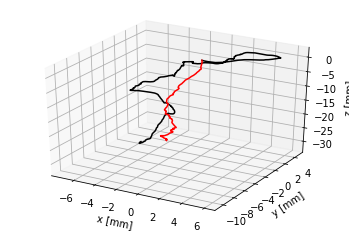

In [ ]:
# relative to absolute
def dump(source_to_target_transformations):
    Ms = []
    cam_to_world = np.eye(4)
    Ms.append(cam_to_world)
    for source_to_target_transformation in source_to_target_transformations:
        cam_to_world = np.dot(source_to_target_transformation, cam_to_world)
        Ms.append(cam_to_world)
    return Ms
pred_p = pred_poses.copy()
pred_p = np.array(dump(pred_p))

gt_p = poses_list.copy()
gt_p.insert(0,np.eye(4)) # gt_p = dump(gt_p)
gt_p = np.array(gt_p)
print(gt_p.shape)

# scale
sum_product = np.sum(gt_p[:, :3, 3] * pred_p[:, :3, 3]) 
scale = sum_product / np.sum(pred_p[:, :3, 3] ** 2) 
print("scale: ", scale)
scaled_p = pred_p * scale

# last column first three 
pred_points = [] 
origin = np.array([[0], [0], [0], [1]]) # (4, 1) 
for i in range(len(scaled_p)):
  pred_points.append(np.dot(scaled_p[i], origin))# last column to a column vec
pred_points = np.array(pred_points)
# the same
gt_points = []
for i in range(len(gt_p)):
  gt_points.append(np.array([gt_p[i,:,3]]).T)
gt_points = np.array(gt_points)

# plot
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
figure1, = ax.plot(gt_points[:, 0, 0], gt_points[:, 1, 0], gt_points[:, 2, 0], c='k')
figure2, = ax.plot(pred_points[:, 0, 0], pred_points[:, 1, 0], pred_points[:, 2, 0], c='r')
plt.savefig('poses.png')
plt.show()

In [ ]:
# 

# evaluate pose

absolute trajectory error

$A T E=\sqrt{\frac{1}{T} \sum_{t=1}^{T}\left\|\operatorname{trans}\left(\boldsymbol{Q}_{t}^{-1} \boldsymbol{\Delta}_{S} \boldsymbol{P}_{t}\right)\right\|}$

Q is the ground truth, P is the estimated, s is the rigid transformation

relative translation error

$R T E=\sqrt{\frac{1}{T} \sum_{t=1}^{T}\left\|\operatorname{trans}\left(\boldsymbol{E}_{t}\right)\right\|}$

relative rotation error

$R R E=\frac{1}{T} \sum_{t=1}^{T}\left\|\operatorname{rot}\left(\boldsymbol{E}_{t}\right)\right\|$



In [ ]:
# Copyright Niantic 2019. Patent Pending. All rights reserved.
#
# This software is licensed under the terms of the Monodepth2 licence
# which allows for non-commercial use only, the full terms of which are made
# available in the LICENSE file.

from __future__ import absolute_import, division, print_function

import os
import numpy as np

import torch
from torch.utils.data import DataLoader



# from https://github.com/tinghuiz/SfMLearner
def compute_ate(gtruth_xyz, pred_xyz_o):

    # Make sure that the first matched frames align (no need for rotational alignment as
    # all the predicted/ground-truth snippets have been converted to use the same coordinate
    # system with the first frame of the snippet being the origin).
    offset = gtruth_xyz[0] - pred_xyz_o[0]
    pred_xyz = pred_xyz_o + offset[None, :]

    # Optimize the scaling factor
    scale = np.sum(gtruth_xyz * pred_xyz) / np.sum(pred_xyz ** 2)
    alignment_error = pred_xyz * scale - gtruth_xyz
    rmse = np.sqrt(np.sum(alignment_error ** 2)) / gtruth_xyz.shape[0]
    return rmse


def evaluate(opt):
    """Evaluate odometry on the KITTI dataset
    """
    assert os.path.isdir(opt.load_weights_folder), \
        "Cannot find a folder at {}".format(opt.load_weights_folder)

    assert opt.eval_split == "odom_9" or opt.eval_split == "odom_10", \
        "eval_split should be either odom_9 or odom_10"

    sequence_id = int(opt.eval_split.split("_")[1])

    filenames = readlines(
        os.path.join(os.path.dirname(__file__), "splits", "odom",
                     "test_files_{:02d}.txt".format(sequence_id)))

    dataset = KITTIOdomDataset(opt.data_path, filenames, opt.height, opt.width,
                               [0, 1], 4, is_train=False)
    dataloader = DataLoader(dataset, opt.batch_size, shuffle=False,
                            num_workers=opt.num_workers, pin_memory=True, drop_last=False)

    pose_encoder_path = os.path.join(opt.load_weights_folder, "pose_encoder.pth")
    pose_decoder_path = os.path.join(opt.load_weights_folder, "pose.pth")

    pose_encoder = networks.ResnetEncoder(opt.num_layers, False, 2)
    pose_encoder.load_state_dict(torch.load(pose_encoder_path))

    pose_decoder = networks.PoseDecoder(pose_encoder.num_ch_enc, 1, 2)
    pose_decoder.load_state_dict(torch.load(pose_decoder_path))

    pose_encoder.cuda()
    pose_encoder.eval()
    pose_decoder.cuda()
    pose_decoder.eval()

    pred_poses = []

    print("-> Computing pose predictions")

    opt.frame_ids = [0, 1]  # pose network only takes two frames as input

    with torch.no_grad():
        for inputs in dataloader:
            for key, ipt in inputs.items():
                inputs[key] = ipt.cuda()

            all_color_aug = torch.cat([inputs[("color_aug", i, 0)] for i in opt.frame_ids], 1)

            features = [pose_encoder(all_color_aug)]
            axisangle, translation = pose_decoder(features)

            pred_poses.append(
                transformation_from_parameters(axisangle[:, 0], translation[:, 0]).cpu().numpy())

    pred_poses = np.concatenate(pred_poses)

    gt_poses_path = os.path.join(opt.data_path, "poses", "{:02d}.txt".format(sequence_id))
    gt_global_poses = np.loadtxt(gt_poses_path).reshape(-1, 3, 4)
    gt_global_poses = np.concatenate(
        (gt_global_poses, np.zeros((gt_global_poses.shape[0], 1, 4))), 1)
    gt_global_poses[:, 3, 3] = 1
    gt_xyzs = gt_global_poses[:, :3, 3]

    gt_local_poses = []
    for i in range(1, len(gt_global_poses)):
        gt_local_poses.append(
            np.linalg.inv(np.dot(np.linalg.inv(gt_global_poses[i - 1]), gt_global_poses[i])))

    ates = []
    num_frames = gt_xyzs.shape[0]
    track_length = 5
    for i in range(0, num_frames - 1):
        local_xyzs = np.array(dump_xyz(pred_poses[i:i + track_length - 1]))
        gt_local_xyzs = np.array(dump_xyz(gt_local_poses[i:i + track_length - 1]))

        ates.append(compute_ate(gt_local_xyzs, local_xyzs))

    print("\n   Trajectory error: {:0.3f}, std: {:0.3f}\n".format(np.mean(ates), np.std(ates)))

    save_path = os.path.join(opt.load_weights_folder, "poses.npy")
    np.save(save_path, pred_poses)
    print("-> Predictions saved to", save_path)


# if __name__ == "__main__":
#     options = MonodepthOptions()
#     evaluate(options.parse())

# poisson surface reconstruction


In [ ]:
!pip -q install transformers
!pip -q install open3d


from transformers import DPTFeatureExtractor, DPTForDepthEstimation

feature_extractor = DPTFeatureExtractor.from_pretrained("Intel/dpt-large")
model = DPTForDepthEstimation.from_pretrained("Intel/dpt-large")

     |████████████████████████████████| 5.8 MB 15.2 MB/s 
     |████████████████████████████████| 7.6 MB 57.5 MB/s 
     |████████████████████████████████| 182 kB 100.5 MB/s 
     |████████████████████████████████| 422.5 MB 36 kB/s 
     |████████████████████████████████| 75 kB 5.0 MB/s 
     |████████████████████████████████| 9.9 MB 92.9 MB/s 
     |████████████████████████████████| 3.2 MB 79.6 MB/s 
     |████████████████████████████████| 1.6 MB 68.6 MB/s 


Downloading:   0%|          | 0.00/285 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/942 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.37G [00:00<?, ?B/s]

Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution2.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


input image size:  (1024, 1280, 3)
DPT depth output size:  torch.Size([1, 384, 384])
monodepth output size:  torch.Size([1, 256, 320])
DPT depth shape:  torch.Size([1, 384, 384])
monodepth output size:  (1024, 1280)
(1024, 1280) (1024, 1280) (1024, 1280, 3)
intrinsic:
 [[1.035e+03 0.000e+00 5.970e+02]
 [0.000e+00 1.035e+03 5.200e+02]
 [0.000e+00 0.000e+00 1.000e+00]]
[Open3D DEBUG] Input Points / Samples: 1310720 / 469971
[Open3D DEBUG] #   Got kernel density: 0.201862 (s), 7784.97 (MB) / 7784.97 (MB) / 7784 (MB)
[Open3D DEBUG] #     Got normal field: 1.16328 (s), 7785.01 (MB) / 7785.01 (MB) / 7785 (MB)
[Open3D DEBUG] Point weight / Estimated Area: 9.310487e-07 / 1.220344e+00
[Open3D DEBUG] #       Finalized tree: 1.37471 (s), 7785.01 (MB) / 7785.01 (MB) / 7785 (MB)
[Open3D DEBUG] #  Set FEM constraints: 3.86483 (s), 7785.01 (MB) / 7785.01 (MB) / 7785 (MB)
[Open3D DEBUG] #Set point constraints: 0.548266 (s), 7785.01 (MB) / 7785.01 (MB) / 7785 (MB)
[Open3D DEBUG] Leaf Nodes / Active Nod

True

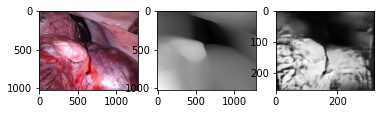

In [ ]:
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import open3d as o3d

# import torch.nn.functional as F

# prepare image for the model
img_path = os.path.join(video2frame_folder, "frame_input%.6d.jpg" % 220)
image_raw = Image.open(img_path).convert('RGB')
plt.subplot(131), plt.imshow(image_raw)
print('input image size: ', np.array(image_raw).shape)
image = image_raw.resize((800, int(800 * image_raw.size[1] / image_raw.size[0])), Image.LANCZOS)# Image.Resampling.LANCZOS)

# predict depth
encoding = feature_extractor(image, return_tensors="pt")
with torch.no_grad():
    outputs = model(**encoding)
    predicted_depth = outputs.predicted_depth
    print('DPT depth output size: ', outputs.predicted_depth.size())# prediction form DPT

depth_image = (pred[('disp',0)][0].detach()) # prediction from Monodepth2
print('monodepth output size: ', depth_image.size())

# interpolate predicted depth to original size
prediction = torch.nn.functional.interpolate(
    predicted_depth.unsqueeze(1),
    size=image_raw.size[::-1],
    mode="bicubic",
    align_corners=False,
).squeeze()
output = prediction.cpu().numpy() 
print('DPT depth shape: ', outputs.predicted_depth.shape)

depth_image = torch.nn.functional.interpolate(
    depth_image.unsqueeze(1),
    size=image_raw.size[::-1],
    mode="bicubic",
    align_corners=False,
).squeeze()
depth_image = (output * 255 / np.max(output)).astype('uint8')
# depth_image = depth_image.cpu().numpy()
print('monodepth output size: ', depth_image.shape)

plt.subplot(132), plt.imshow(output, cmap='gray')
plt.subplot(133), plt.imshow(pred[('disp',0)][0][0].detach().cpu(), cmap='gray')
print(depth_image.shape, output.shape, np.array(image_raw).shape)

# rgbd
depth_o3d = o3d.geometry.Image(depth_image)
image_o3d = o3d.geometry.Image(np.array(image_raw))
rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(
    image_o3d, depth_o3d, convert_rgb_to_intensity=False)

# intrinsic
h = int(depth_image.shape[0])
w = int(depth_image.shape[1])
camera_intrinsic = o3d.camera.PinholeCameraIntrinsic()
# camera_intrinsic.set_intrinsics(w, h, 500, 500, w/2, h/2)#500, 500, 640,512
camera_intrinsic.set_intrinsics(w, h, 1035, 1035, 597, 520)#1035, 1035, 597,520
print('intrinsic:\n', camera_intrinsic.intrinsic_matrix)

# rgbd intrin pcd
# invalidate existing normals
pcd = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image, camera_intrinsic)
pcd.normals = o3d.utility.Vector3dVector(np.zeros((1, 3)))  
pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.01, max_nn=30))
pcd.orient_normals_towards_camera_location(camera_location=np.array([0., 0., 1000.]))
pcd.transform([[1, 0, 0, 0],
                [0, -1, 0, 0],
                [0, 0, -1, 0],
                [0, 0, 0, 1]])
pcd.transform([[-1, 0, 0, 0],
                [0, 1, 0, 0],
                [0, 0, 1, 0],
                [0, 0, 0, 1]]) 

# run Poisson surface reconstruction
with o3d.utility.VerbosityContextManager(o3d.utility.VerbosityLevel.Debug) as cm:
    mesh_raw, densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(
        pcd, depth=10, width=0, scale=1.1, linear_fit=True)

voxel_size = max(mesh_raw.get_max_bound() - mesh_raw.get_min_bound()) / 256
print(f'voxel_size = {voxel_size:e}')
mesh = mesh_raw.simplify_vertex_clustering(
    voxel_size=voxel_size,
    contraction=o3d.geometry.SimplificationContraction.Average)

# vertices_to_remove = densities < np.quantile(densities, 0.001)
# mesh.remove_vertices_by_mask(vertices_to_remove)
bbox = pcd.get_axis_aligned_bounding_box() 
mesh_crop = mesh.crop(bbox)
gltf_path = f'./{img_path}.gltf'
o3d.io.write_triangle_mesh(gltf_path, mesh_crop, write_triangle_uvs=True)

In [ ]:
import torch.nn as nn

class BackprojectDepth(nn.Module):
    """Layer to transform a depth image into a point cloud
    """
    def __init__(self, batch_size, height, width):
        super(BackprojectDepth, self).__init__()

        self.batch_size = batch_size
        self.height = height
        self.width = width

        meshgrid = np.meshgrid(range(self.width), range(self.height), indexing='xy')#cartesian coordinates
        self.id_coords = np.stack(meshgrid, axis=0).astype(np.float32)
        self.id_coords = nn.Parameter(torch.from_numpy(self.id_coords),
                                      requires_grad=False)#learnable parameters

        self.ones = nn.Parameter(torch.ones(self.batch_size, 1, self.height * self.width),
                                 requires_grad=False)

        self.pix_coords = torch.unsqueeze(torch.stack(
            [self.id_coords[0].view(-1), self.id_coords[1].view(-1)], 0), 0)
        self.pix_coords = self.pix_coords.repeat(batch_size, 1, 1)
        self.pix_coords = nn.Parameter(torch.cat([self.pix_coords, self.ones], 1),
                                       requires_grad=False)#

    def forward(self, depth, inv_K):
        print('pixel -> camera -> depth')
        # print(inv_K.device, self.pix_coords.device)
        # print(inv_K[:, :3, :3].size(),self.pix_coords.size())#torch.Size([1, 3, 3]) torch.Size([1, 3, 81920])
        cam_points = torch.matmul(inv_K[:, :3, :3], self.pix_coords)#[3,3][] #drop last colomn and last row
        print('pixel_coord: ', self.pix_coords.size(), 'k_inv: ', inv_K[:, :3, :3].size(),'cam: ',cam_points.size(), 'depth:',depth.view(self.batch_size, 1, -1).size())
        # print('pixel_coord: ', self.pix_coords.device, 'k_inv: ', inv_K[:, :3, :3].device,'cam: ',cam_points.device, 'depth:',depth.view(self.batch_size, 1, -1).device)
        cam_points = depth.view(self.batch_size, 1, -1) * cam_points #camera multiply depth
        cam_points = torch.cat([cam_points, self.ones], 1) 

        return cam_points


class Project3D(nn.Module):
    """Layer which projects 3D points into a camera with intrinsics K and at position T
    """
    def __init__(self, batch_size, height, width, eps=1e-7):
        super(Project3D, self).__init__()

        self.batch_size = batch_size
        self.height = height
        self.width = width
        self.eps = eps

    def forward(self, points, K, T):
        # print('K: ', K.device, 'T: ', T.device)
        P = torch.matmul(K, T)[:, :3, :] #K multiply T
        print('world -> camera -> pixel')
        # print('KT: ', P.device, 'point cloud: ', points.device)
        cam_points = torch.matmul(P, points) #K multiply T multiply points, from world to camera then to image
        print('KT: ', P.size(), 'point cloud: ', points.size(), '3d to 2d: ', cam_points.size())
        #cam_points to pixel coords: torch.Size([1, 3, 49152])#torch.Size([1, 2, 49152])#torch.Size([1, 1, 49152])
        pix_coords = cam_points[:, :2, :] / (cam_points[:, 2, :].unsqueeze(1) + self.eps)#+ self.eps barely no change
        print('pixel coordinate: ', cam_points.shape)
        pix_coords = pix_coords.view(self.batch_size, 2, self.height, self.width)
        print('pix coordinate view batch, 2, h, w', pix_coords.shape)
        pix_coords = pix_coords.permute(0, 2, 3, 1)#batch, h, w, 2
        pix_coords[..., 0] /= self.width - 1 #a[...,0]==a[:,:,0])
        pix_coords[..., 1] /= self.height - 1 # 
        pix_coords = (pix_coords - 0.5) * 2
        return pix_coords

def disp_to_depth(disp, min_depth, max_depth):
    """Convert network's sigmoid output into depth prediction
    The formula for this conversion is given in the 'additional considerations'
    section of the paper.
    """
    min_disp = 1 / max_depth
    max_disp = 1 / min_depth
    scaled_disp = min_disp + (max_disp - min_disp) * disp
    depth = 1 / scaled_disp
    return scaled_disp, depth

In [ ]:
import torch.nn.functional as F

print(inputs.keys())
backproject_depth = {}
project_3d = {}
disp = pred[('disp',0)]# disp = outputs[("disp", scale)]
_, depth = disp_to_depth(disp, 0.1, 100) #torch.Size([1, 1, h, w])
depth = depth.to(device)
outputs["depth"] = depth# outputs[("depth", 0, scale)] = depth

scales=range(1)
width = 320
height = 256
# K = np.array([[0.58, 0, 0.5, 0],
#               [0, 1.92, 0.5, 0],
#               [0,    0,   1, 0],
#               [0,    0,   0, 1]], dtype=np.float32)
K = np.array([[1.18849248e+03, 0.00000000e+00, 6.41449814e+02, 0.00000000e+00],
              [0.00000000e+00, 1.18849248e+03, 5.20022934e+02, 0.00000000e+00],
              [0,                           0,              1,              0],
              [0,                           0,              0,              1]], dtype=np.float32)

for scale in scales:
    h = height // (2 ** scale)
    w = width // (2 ** scale)  

    backproject_depth[scale] = BackprojectDepth(1, h, w)#batch size
    backproject_depth[scale].to(device)

    project_3d[scale] = Project3D(1, h, w)
    project_3d[scale].to(device)     
    K = K.copy()
    K[0, :] *= width // (2 ** scale)
    K[1, :] *= height // (2 ** scale)
    inv_K = np.linalg.pinv(K)
    inputs[("K", scale)] = torch.from_numpy(K).to(device)
    inputs[("inv_K", scale)] = torch.from_numpy(inv_K).to(device)
    K = torch.from_numpy(K)

scale = 0
source_scale = scale

for i, frame_id in enumerate([1]):

    # T = outputs[("cam_T_cam", 0, frame_id)] 
    # axisangle = outputs[("axisangle", 0, frame_id)]
    # translation = outputs[("translation", 0, frame_id)]
    T = outputs["M"].to(device)
    axisangle = outputs['axisangle']
    translation = outputs['translation']
    inv_depth = 1 / depth
    mean_inv_depth = inv_depth.mean(3, True).mean(2, True)
    cam_points = backproject_depth[source_scale](depth, inputs[("inv_K", source_scale)][None])   # 2d depth to 3d point cloud     
    print('3d: ', cam_points.size())
    pix_coords = project_3d[source_scale](
        cam_points, inputs[("K", source_scale)][None], T)# 3d point cloud to 2d
    print('2d: ', pix_coords.size())
    outputs[("sample", frame_id, scale)] = pix_coords #2d reconstruction
    outputs[("color", frame_id, scale)] = F.grid_sample(
        inputs[("color", frame_id, source_scale)][None].to(device),
        outputs[("sample", frame_id, scale)],
        padding_mode="border") #warping  ##input N,C,H_in,W_in , grid N,H_out,W_out,2
print('input: ', inputs[("color", frame_id, scale)].squeeze().permute(1,2,0).size())
print('output: ', outputs[("sample", frame_id, scale)].squeeze().permute(1,2,0).size())
plt.imshow(inputs[("color", frame_id, scale)].squeeze().permute(1,2,0).cpu().detach().numpy()),plt.show()
plt.imshow(outputs[("color", frame_id, scale)].squeeze().permute(1,2,0).cpu().detach().numpy())

In [ ]:
print(inputs.keys())
print(outputs.keys())

#retrain pose networks

In [ ]:
from abc import ABC
import torch.nn as nn

class RelPoseCriterion(nn.Module, ABC):
    def __init__(self, alpha=1):
        super().__init__()
        self.alpha = alpha
        self.q_loss = nn.MSELoss()
        self.t_loss = nn.MSELoss()

    def forward(self, q_gt, t_gt, q_est, t_est):
        t_loss = self.t_loss(t_est, t_gt)
        q_loss = self.q_loss(q_est, q_gt)

        loss_total = t_loss + self.alpha * q_loss
        return loss_total, t_loss.item(), q_loss.item()

#Retrain depth networks

mse (l2) = $\frac{1}{n}\sum_{i=1}^{n}(pred_i - gt_i)^2$

mae (l1) = $\left\|pred_i - gt_i\right\| = \frac{1}{n}\sum_{i=1}^{n}|pred_i - gt_i|$

sq rel =  $\frac{1}{n}\sum_{i=1}^{n}(pred_i - gt_i)^2/gt_i$

abs rel = $\frac{1}{n}\sum_{i=1}^{n}|pred_i - gt_i|/gt_i$

rmse = $\sqrt{\frac{1}{n}\sum_{i=1}^{n}(pred_i - gt_i)^2}$

rmse log = $\sqrt{\frac{1}{n}\sum_{i=1}^{n}(\log pred_i - \log gt_i)^2}$

appearance loss: $C_{a p}=\frac{1}{n} \sum_{i=1}^{n} \alpha \frac{1-\operatorname{SSIM}(pred_i - gt_i)}{2}+(1-\alpha)\left\|pred_i - gt_i\right\|$ $, \alpha$ was set to 0.85

disparity smoothness loss: $C_{d s}=\frac{1}{n} \sum_{i}^{n}(\partial_{x} pred_{i}) e^{-\left\|\partial_{x} Image\right\|}+(\partial_{y} pred_{i}) e^{-\left\|\partial_{y} Image\right\|}$ 

In [ ]:
!mkdir weights

In [ ]:
!mkdir weights/ssim

In [ ]:
os.chdir('/content')
%cd content
import torch
import torch.optim as optim
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torchmetrics.functional import mean_absolute_error

import torchvision.transforms as transforms
from PIL import Image
import os


import math
import torch.nn.functional as F
import numpy as np
from torchmetrics import StructuralSimilarityIndexMeasure

device = 'cuda' if torch.cuda.is_available() else 'cpu'


class SSIM_Loss_Lib(nn.Module):
    def __init__(self, data_range=1):
        super().__init__()
        self.ssim = StructuralSimilarityIndexMeasure(data_range=data_range)

    def forward(self, img1, img2):
        return 1 - self.ssim(img1, img2)


class Photometric_Loss(nn.Module):
    def __init__(self):
        super().__init__()

    def SSIM(self, x, y):
      C1 = 0.01 ** 2
      C2 = 0.03 ** 2

      mu_x = nn.AvgPool2d(3, 1)(x)
      mu_y = nn.AvgPool2d(3, 1)(y)
      mu_x_mu_y = mu_x * mu_y
      mu_x_sq = mu_x.pow(2)
      mu_y_sq = mu_y.pow(2)

      sigma_x = nn.AvgPool2d(3, 1)(x * x) - mu_x_sq
      sigma_y = nn.AvgPool2d(3, 1)(y * y) - mu_y_sq
      sigma_xy = nn.AvgPool2d(3, 1)(x * y) - mu_x_mu_y

      SSIM_n = (2 * mu_x_mu_y + C1) * (2 * sigma_xy + C2)
      SSIM_d = (mu_x_sq + mu_y_sq + C1) * (sigma_x + sigma_y + C2)
      SSIM = SSIM_n / SSIM_d

      return torch.clamp((1 - SSIM) / 2, 0, 1)


    def forward(self, img1, img2, img = None):#output label image
      ssim = torch.mean(self.SSIM(img1,img2))
      l1 = torch.mean(torch.abs(img1 - img2))
      photometric_loss = 0.85 * ssim+ 0.15 * l1
      return photometric_loss


class Disparity_Smoothness(Photometric_Loss):
  def __init__(self):
      super(Photometric_Loss, self).__init__()  

  def gradient_x(self, img):
      # Pad input to keep output size consistent
      img = F.pad(img, (0, 1, 0, 0), mode="replicate")
      gx = img[:, :, :, :-1] - img[:, :, :, 1:]  # NCHW
      return gx

  def gradient_y(self, img):
      # Pad input to keep output size consistent
      img = F.pad(img, (0, 0, 0, 1), mode="replicate")
      gy = img[:, :, :-1, :] - img[:, :, 1:, :]  # NCHW
      return gy

  def disp_smoothness(self, depth, img):
      disp_gradients_x = self.gradient_x(depth)  # NCHW
      disp_gradients_y = self.gradient_y(depth)  # NCHW

      image_gradients_x = self.gradient_x(img)  # NCHW
      image_gradients_y = self.gradient_y(img)  # NCHW

      weights_x = torch.exp(-torch.mean(torch.abs(image_gradients_x), 1,keepdim=True))
      weights_y = torch.exp(-torch.mean(torch.abs(image_gradients_y), 1,keepdim=True))

      smoothness_x = disp_gradients_x * weights_x
      smoothness_y = disp_gradients_y * weights_y#[1,1,1280,1024]

      smoothness = torch.mean(smoothness_x) + torch.mean(smoothness_y)
      return smoothness

  def forward(self, img1, img2, img):#output label image
      ssim = torch.mean(self.SSIM(img1,img2))
      l1 = torch.mean(torch.abs(img1 - img2))
      gradient = self.disp_smoothness(img1, img)
      photometric_loss = 0.85 * ssim+ 0.15 * l1 +0.1 * gradient
      return photometric_loss

# def train(model, trainloader, optimizer, criterion, scheduler):
def train(model, trainloader, optimizer, criterion):
    model[0].train()
    model[1].train()
    for i_batch, s_batch in enumerate(trainloader):
        image_batch, label_batch = s_batch[0].to(device), s_batch[1].to(device)
        features = model[0](image_batch)
        outputs = model[1](features)
        #outputs = model(image_batch)
        if isinstance(criterion,Disparity_Smoothness):
          loss = criterion(outputs[('disp', 0)], label_batch, image_batch)
          #loss = criterion(outputs, label_batch, image_batch)
        else:  
          #loss = criterion(outputs, label_batch, image_batch)
          loss = criterion(outputs[('disp', 0)], label_batch)#[batch_size, 1, 256, 320]
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # scheduler.step()

def test(model, testloader):
    model[0].eval()
    model[1].eval()
    ssim = StructuralSimilarityIndexMeasure(data_range=1)
    mse_all = []
    ssim_all = []
    rmse_all = []
    rmselog_all = []
    mae_rel_all = []
    mse_rel_all = []
    a1 = []
    a2 = []
    a3 = []
    with torch.no_grad():
        for i_batch, s_batch in enumerate(testloader):
            image_batch, label_batch = s_batch[0].to(device), s_batch[1].to(device)
            features = model[0](image_batch)
            outputs = model[1](features)
            #outputs = model(image_batch)
            outputs = outputs[('disp', 0)]
            outputs = nn.Sigmoid()(outputs)
            mse = nn.MSELoss()(outputs, label_batch)
            mse_all.append(mse.item())
            ssim_all.append(ssim(outputs.detach().cpu(), label_batch.detach().cpu()).item())
            rmse_all.append(math.sqrt(mse.item()))
            rmselog_all.append(math.sqrt(nn.MSELoss()(torch.log(outputs), torch.log(label_batch)).item()))
            mse_rel_all.append(mse.item() / label_batch[i_batch][0].detach().cpu().numpy())
            mae_rel_all.append(nn.L1Loss()(outputs, label_batch).item() / label_batch[i_batch][0].detach().cpu().numpy())
            thresh = np.maximum((label_batch / outputs).detach().cpu(), (outputs / label_batch).detach().cpu())
            # a1.append(thresh < 1.25     ).mean()
            # a2.append(thresh < 1.25 ** 2).mean()
            # a3.append(thresh < 1.25 ** 3).mean()
        return np.mean(mse_all), np.mean(ssim_all), np.mean(rmse_all), np.mean(rmselog_all), np.mean(mse_rel_all),  np.mean(mae_rel_all[0])


def main():
    seed_everything()
    args = get_args()

    print("Sample size- Train:%d, Valid: %d"%(len(dataset_train), len(dataset_valid)))
    #github: https://github.com/mateuszbuda/brain-segmentation-pytorch/blob/master/unet.py
    # model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
    #         in_channels=3, out_channels=1, init_features=32, pretrained=False)
    # model.to(device)
    encoder.to(device)
    depth_decoder.to(device)
    models = []
    models.append(encoder)
    models.append(depth_decoder)


    args.criterion = 'ssim'

    if args.criterion == 'mse':        
        criterion = nn.MSELoss().to(device)
    elif args.criterion == 'l1':        
        criterion = nn.L1Loss().to(device)
    elif args.criterion == 'ssim':        
        criterion = SSIM_Loss_Lib(data_range=1.0).to(device)
    elif args.criterion == 'bce':
        criterion = nn.BCELoss().to(device)
    elif args.criterion == 'photometric':
        criterion = Photometric_Loss().to(device)
    elif args.criterion == 'smoothness':
        criterion = Disparity_Smoothness().to(device)
    
    parameters = []
    parameters += list(models[0].parameters())
    parameters += list(models[1].parameters())

    optimizer = optim.AdamW(parameters, 1e-4)
    #optimizer = optim.AdamW(model.parameters(), lr=args.lr)
    #optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=0.9, weight_decay=0.0001)
    # scheduler = optim.lr_scheduler.StepLR(optimizer, 10, 0.1)
    best_mse, best_ssim, best_rmse, best_rmselog, best_mse_rel, best_mae_rel, best_epoch = np.inf, 0, np.inf,np.inf,np.inf,np.inf,0
    best_mse_epoch, best_ssim_epoch, best_rmse_epoch, best_rmselog_epoch, best_mse_rel_epoch, best_mae_rel_epoch = 0,0,0,0,0,0
    for epoch_num in range(args.max_epochs):
        #train(model, train_loader, optimizer, criterion)
        # train(models, train_loader, optimizer, criterion, scheduler)
        train(models, train_loader, optimizer, criterion)
        mse, ssim, rmse, rmselog, mse_rel, mae_rel = test(models, valid_loader)
        if mse < best_mse:
            best_mse = mse
            best_mse_epoch = epoch_num
            torch.save(models[0].state_dict(), os.path.join("weights", args.criterion,"encoder_mse.pth"))
            torch.save(models[1].state_dict(), os.path.join("weights", args.criterion,"decoder_mse.pth"))
 
        if ssim > best_ssim:
            best_ssim = ssim
            best_ssim_epoch = epoch_num
            torch.save(models[0].state_dict(), os.path.join("weights", args.criterion, "encoder_ssim.pth"))
            torch.save(models[1].state_dict(), os.path.join("weights", args.criterion, "decoder_ssim.pth"))

        if rmse < best_rmse:
            best_rmse = rmse
            best_rmse_epoch = epoch_num
            # torch.save(models[0].state_dict(), os.path.join("weights", args.criterion,"encoder_rmse.pth"))
            # torch.save(models[1].state_dict(), os.path.join("weights", args.criterion,"decoder_rmse.pth"))

        if rmselog < best_rmselog:
            best_rmselog = rmselog
            best_rmselog_epoch = epoch_num
            # torch.save(models[0].state_dict(), os.path.join("weights", args.criterion,"encoder_rmselog.pth"))
            # torch.save(models[1].state_dict(), os.path.join("weights", args.criterion,"decoder_rmselog.pth"))

        if mse_rel < best_mse_rel:
            best_mse_rel = mse_rel
            best_mse_rel_epoch = epoch_num
            # torch.save(models[0].state_dict(), os.path.join("weights", args.criterion,"encoder_mserel.pth"))
            # torch.save(models[1].state_dict(), os.path.join("weights", args.criterion,"decoder_mserel.pth"))

        if mae_rel < best_mae_rel:
            best_mae_rel = mae_rel
            best_mae_rel_epoch = epoch_num
            # torch.save(models[0].state_dict(), os.path.join("weights", args.criterion,"encoder_maerel.pth"))
            # torch.save(models[1].state_dict(), os.path.join("weights", args.criterion,"decoder_maerel.pth"))
           
        print('Epoch:{}, Curr MSE(L2):{:.4f}, RMSE:{:.4f}, RMSElog:{:.4f}, sq rel:{:.4f}, abs rel:{:.4f}, MSE(L2):{:.4f}, SSIM:{:.4f},  Best Epoch:{}, Criterion:{}, Lr:{}'.
                format(epoch_num, mse, rmse, rmselog, mse_rel, mae_rel, mse, ssim,  best_epoch, args.criterion, optimizer.param_groups[0]['lr']))
        print("   best epoch for each mse:{}, ssim:{}, rmse:{}, rmselog:{}, sqrrel:{}, absrel:{}".format(best_mse_epoch, best_ssim_epoch, best_rmse_epoch, best_rmselog_epoch, best_mse_rel_epoch, best_mae_rel_epoch))
    weights = {}
    weights["encoder"] = []
    weights["decoder"] = []
    weights["encoder"].append("{}_{}_{:03d}.pth".format("encoder", args.criterion, best_epoch))
    weights["decoder"].append("{}_{}_{:03d}.pth".format("decoder", args.criterion, best_epoch))
if __name__ == "__main__":
    main()

poch:64, Curr MSE(L2):0.0754, RMSE:0.2736, RMSElog:0.9266, sq rel:0.2239, abs rel:0.8920, MSE(L2):0.0754, SSIM:0.3736,  Best Epoch:0, Criterion:l1, Lr:0.0001
   best epoch for each mse:64, ssim:64, rmse:64, rmselog:64, sqrrel:64, absrel:64


Epoch:36, Curr MSE(L2):0.0761, RMSE:0.2748, RMSElog:0.9292, sq rel:0.2263, abs rel:0.9009, MSE(L2):0.0761, SSIM:0.3724,  Best Epoch:0, Criterion:bce, Lr:0.0001
   best epoch for each mse:36, ssim:36, rmse:36, rmselog:36, sqrrel:36, absrel:35


Epoch:61, Curr MSE(L2):0.0760, RMSE:0.2745, RMSElog:0.9289, sq rel:0.2258, abs rel:0.8987, MSE(L2):0.0760, SSIM:0.3732,  Best Epoch:0, Criterion:mse, Lr:0.0001
   best epoch for each mse:61, ssim:61, rmse:61, rmselog:58, sqrrel:58, absrel:58
Epoch:62, Curr MSE(L2):0.0767, RMSE:0.2758, RMSElog:0.9311, sq rel:0.2279, abs rel:0.9024, MSE(L2):0.0767, SSIM:0.3727,  Best Epoch:0, Criterion:mse, Lr:0.0001
   best epoch for each mse:61, ssim:61, rmse:61, rmselog:58, sqrrel:58, absrel:58
Epoch:63, Curr MSE(L2):0.0764, RMSE:0.2753, RMSElog:0.9304, sq rel:0.2270, abs rel:0.9000, MSE(L2):0.0764, SSIM:0.3730,  Best Epoch:0, Criterion:mse, Lr:0.0001
   best epoch for each mse:61, ssim:61, rmse:61, rmselog:58, sqrrel:58, absrel:58
Epoch:64, Curr MSE(L2):0.0762, RMSE:0.2750, RMSElog:0.9299, sq rel:0.2265, abs rel:0.8980, MSE(L2):0.0762, SSIM:0.3733,  Best Epoch:0, Criterion:mse, Lr:0.0001
   best epoch for each mse:61, ssim:64, rmse:61, rmselog:58, sqrrel:58, absrel:64
Epoch:65, Curr MSE(L2):0.0762, RMSE:0.2749, RMSElog:0.9299, sq rel:0.2264, abs rel:0.8985, MSE(L2):0.0762, SSIM:0.3734,  Best Epoch:0, Criterion:mse, Lr:0.0001
   best epoch for each mse:61, ssim:65, rmse:61, rmselog:58, sqrrel:58, absrel:64
Epoch:66, Curr MSE(L2):0.0768, RMSE:0.2760, RMSElog:0.9317, sq rel:0.2281, abs rel:0.9022, MSE(L2):0.0768, SSIM:0.3729,  Best Epoch:0, Criterion:mse, Lr:0.0001
   best epoch for each mse:61, ssim:65, rmse:61, rmselog:58, sqrrel:58, absrel:64
Epoch:67, Curr MSE(L2):0.0771, RMSE:0.2766, RMSElog:0.9326, sq rel:0.2291, abs rel:0.9037, MSE(L2):0.0771, SSIM:0.3726,  Best Epoch:0, Criterion:mse, Lr:0.0001
   best epoch for each mse:61, ssim:65, rmse:61, rmselog:58, sqrrel:58, absrel:64
Epoch:68, Curr MSE(L2):0.0763, RMSE:0.2752, RMSElog:0.9303, sq rel:0.2269, abs rel:0.9003, MSE(L2):0.0763, SSIM:0.3732,  Best Epoch:0, Criterion:mse, Lr:0.0001
   best epoch for each mse:61, ssim:65, rmse:61, rmselog:58, sqrrel:58, absrel:64
Epoch:69, Curr MSE(L2):0.0765, RMSE:0.2755, RMSElog:0.9307, sq rel:0.2273, abs rel:0.9006, MSE(L2):0.0765, SSIM:0.3731,  Best Epoch:0, Criterion:mse, Lr:0.0001
   best epoch for each mse:61, ssim:65, rmse:61, rmselog:58, sqrrel:58, absrel:64
Epoch:70, Curr MSE(L2):0.0764, RMSE:0.2752, RMSElog:0.9303, sq rel:0.2268, abs rel:0.8995, MSE(L2):0.0764, SSIM:0.3732,  Best Epoch:0, Criterion:mse, Lr:0.0001
   best epoch for each mse:61, ssim:65, rmse:61, rmselog:58, sqrrel:58, absrel:64
Epoch:71, Curr MSE(L2):0.0765, RMSE:0.2755, RMSElog:0.9306, sq rel:0.2272, abs rel:0.9006, MSE(L2):0.0765, SSIM:0.3731,  Best Epoch:0, Criterion:mse, Lr:0.0001
   best epoch for each mse:61, ssim:65, rmse:61, rmselog:58, sqrrel:58, absrel:64
Epoch:72, Curr MSE(L2):0.0766, RMSE:0.2757, RMSElog:0.9310, sq rel:0.2275, abs rel:0.9004, MSE(L2):0.0766, SSIM:0.3731,  Best Epoch:0, Criterion:mse, Lr:0.0001
   best epoch for each mse:61, ssim:65, rmse:61, rmselog:58, sqrrel:58, absrel:64
Epoch:73, Curr MSE(L2):0.0766, RMSE:0.2757, RMSElog:0.9312, sq rel:0.2275, abs rel:0.9000, MSE(L2):0.0766, SSIM:0.3731,  Best Epoch:0, Criterion:mse, Lr:0.0001
   best epoch for each mse:61, ssim:65, rmse:61, rmselog:58, sqrrel:58, absrel:64
Epoch:74, Curr MSE(L2):0.0761, RMSE:0.2748, RMSElog:0.9297, sq rel:0.2260, abs rel:0.8976, MSE(L2):0.0761, SSIM:0.3735,  Best Epoch:0, Criterion:mse, Lr:0.0001
   best epoch for each mse:61, ssim:74, rmse:61, rmselog:58, sqrrel:58, absrel:74


Epoch:37, Curr MSE(L2):0.0736, RMSE:0.2701, RMSElog:0.9208, sq rel:0.2192, abs rel:0.8864, MSE(L2):0.0736, SSIM:0.3756,  Best Epoch:0, Criterion:photometric, Lr:0.0001
   best epoch for each mse:37, ssim:37, rmse:37, rmselog:37, sqrrel:37, absrel:37
Epoch:38, Curr MSE(L2):0.0743, RMSE:0.2714, RMSElog:0.9225, sq rel:0.2211, abs rel:0.8903, MSE(L2):0.0743, SSIM:0.3754,  Best Epoch:0, Criterion:photometric, Lr:0.0001
   best epoch for each mse:37, ssim:37, rmse:37, rmselog:37, sqrrel:37, absrel:37
Epoch:39, Curr MSE(L2):0.0745, RMSE:0.2717, RMSElog:0.9231, sq rel:0.2217, abs rel:0.8933, MSE(L2):0.0745, SSIM:0.3752,  Best Epoch:0, Criterion:photometric, Lr:0.0001
   best epoch for each mse:37, ssim:37, rmse:37, rmselog:37, sqrrel:37, absrel:37
Epoch:40, Curr MSE(L2):0.0744, RMSE:0.2715, RMSElog:0.9229, sq rel:0.2213, abs rel:0.8913, MSE(L2):0.0744, SSIM:0.3749,  Best Epoch:0, Criterion:photometric, Lr:0.0001
   best epoch for each mse:37, ssim:37, rmse:37, rmselog:37, sqrrel:37, absrel:37
Epoch:41, Curr MSE(L2):0.0745, RMSE:0.2718, RMSElog:0.9232, sq rel:0.2215, abs rel:0.8897, MSE(L2):0.0745, SSIM:0.3749,  Best Epoch:0, Criterion:photometric, Lr:0.0001
   best epoch for each mse:37, ssim:37, rmse:37, rmselog:37, sqrrel:37, absrel:37
Epoch:42, Curr MSE(L2):0.0737, RMSE:0.2702, RMSElog:0.9210, sq rel:0.2193, abs rel:0.8870, MSE(L2):0.0737, SSIM:0.3760,  Best Epoch:0, Criterion:photometric, Lr:0.0001
   best epoch for each mse:37, ssim:42, rmse:37, rmselog:37, sqrrel:37, absrel:37
Epoch:43, Curr MSE(L2):0.0744, RMSE:0.2717, RMSElog:0.9232, sq rel:0.2215, abs rel:0.8908, MSE(L2):0.0744, SSIM:0.3755,  Best Epoch:0, Criterion:photometric, Lr:0.0001
   best epoch for each mse:37, ssim:42, rmse:37, rmselog:37, sqrrel:37, absrel:37
Epoch:44, Curr MSE(L2):0.0749, RMSE:0.2725, RMSElog:0.9245, sq rel:0.2230, abs rel:0.8948, MSE(L2):0.0749, SSIM:0.3749,  Best Epoch:0, Criterion:photometric, Lr:0.0001
   best epoch for each mse:37, ssim:42, rmse:37, rmselog:37, sqrrel:37, absrel:37
Epoch:45, Curr MSE(L2):0.0739, RMSE:0.2706, RMSElog:0.9217, sq rel:0.2200, abs rel:0.8886, MSE(L2):0.0739, SSIM:0.3760,  Best Epoch:0, Criterion:photometric, Lr:0.0001
   best epoch for each mse:37, ssim:42, rmse:37, rmselog:37, sqrrel:37, absrel:37
Epoch:46, Curr MSE(L2):0.0741, RMSE:0.2710, RMSElog:0.9220, sq rel:0.2203, abs rel:0.8875, MSE(L2):0.0741, SSIM:0.3761,  Best Epoch:0, Criterion:photometric, Lr:0.0001
   best epoch for each mse:37, ssim:46, rmse:37, rmselog:37, sqrrel:37, absrel:37
Epoch:47, Curr MSE(L2):0.0737, RMSE:0.2703, RMSElog:0.9208, sq rel:0.2194, abs rel:0.8872, MSE(L2):0.0737, SSIM:0.3768,  Best Epoch:0, Criterion:photometric, Lr:0.0001
   best epoch for each mse:37, ssim:47, rmse:37, rmselog:37, sqrrel:37, absrel:37
Epoch:48, Curr MSE(L2):0.0745, RMSE:0.2717, RMSElog:0.9231, sq rel:0.2217, abs rel:0.8915, MSE(L2):0.0745, SSIM:0.3754,  Best Epoch:0, Criterion:photometric, Lr:0.0001
   best epoch for each mse:37, ssim:47, rmse:37, rmselog:37, sqrrel:37, absrel:37
Epoch:49, Curr MSE(L2):0.0743, RMSE:0.2714, RMSElog:0.9228, sq rel:0.2213, abs rel:0.8919, MSE(L2):0.0743, SSIM:0.3756,  Best Epoch:0, Criterion:photometric, Lr:0.0001
   best epoch for each mse:37, ssim:47, rmse:37, rmselog:37, sqrrel:37, absrel:37
Epoch:50, Curr MSE(L2):0.0739, RMSE:0.2707, RMSElog:0.9214, sq rel:0.2199, abs rel:0.8878, MSE(L2):0.0739, SSIM:0.3766,  Best Epoch:0, Criterion:photometric, Lr:0.0001
   best epoch for each mse:37, ssim:47, rmse:37, rmselog:37, sqrrel:37, absrel:37
Epoch:51, Curr MSE(L2):0.0750, RMSE:0.2727, RMSElog:0.9247, sq rel:0.2229, abs rel:0.8931, MSE(L2):0.0750, SSIM:0.3760,  Best Epoch:0, Criterion:photometric, Lr:0.0001
   best epoch for each mse:37, ssim:47, rmse:37, rmselog:37, sqrrel:37, absrel:37
Epoch:52, Curr MSE(L2):0.0749, RMSE:0.2724, RMSElog:0.9247, sq rel:0.2227, abs rel:0.8933, MSE(L2):0.0749, SSIM:0.3758,  Best Epoch:0, Criterion:photometric, Lr:0.0001
   best epoch for each mse:37, ssim:47, rmse:37, rmselog:37, sqrrel:37, absrel:37
Epoch:53, Curr MSE(L2):0.0741, RMSE:0.2711, RMSElog:0.9223, sq rel:0.2203, abs rel:0.8861, MSE(L2):0.0741, SSIM:0.3763,  Best Epoch:0, Criterion:photometric, Lr:0.0001
   best epoch for each mse:37, ssim:47, rmse:37, rmselog:37, sqrrel:37, absrel:53
Epoch:54, Curr MSE(L2):0.0741, RMSE:0.2710, RMSElog:0.9221, sq rel:0.2204, abs rel:0.8889, MSE(L2):0.0741, SSIM:0.3767,  Best Epoch:0, Criterion:photometric, Lr:0.0001
   best epoch for each mse:37, ssim:47, rmse:37, rmselog:37, sqrrel:37, absrel:53
Epoch:55, Curr MSE(L2):0.0747, RMSE:0.2721, RMSElog:0.9240, sq rel:0.2223, abs rel:0.8929, MSE(L2):0.0747, SSIM:0.3761,  Best Epoch:0, Criterion:photometric, Lr:0.0001
   best epoch for each mse:37, ssim:47, rmse:37, rmselog:37, sqrrel:37, absrel:53
Epoch:56, Curr MSE(L2):0.0742, RMSE:0.2713, RMSElog:0.9227, sq rel:0.2209, abs rel:0.8896, MSE(L2):0.0742, SSIM:0.3768,  Best Epoch:0, Criterion:photometric, Lr:0.0001
   best epoch for each mse:37, ssim:56, rmse:37, rmselog:37, sqrrel:37, absrel:53
Epoch:57, Curr MSE(L2):0.0741, RMSE:0.2711, RMSElog:0.9223, sq rel:0.2203, abs rel:0.8869, MSE(L2):0.0741, SSIM:0.3768,  Best Epoch:0, Criterion:photometric, Lr:0.0001
   best epoch for each mse:37, ssim:57, rmse:37, rmselog:37, sqrrel:37, absrel:53
Epoch:58, Curr MSE(L2):0.0738, RMSE:0.2704, RMSElog:0.9213, sq rel:0.2194, abs rel:0.8863, MSE(L2):0.0738, SSIM:0.3772,  Best Epoch:0, Criterion:photometric, Lr:0.0001
   best epoch for each mse:37, ssim:58, rmse:37, rmselog:37, sqrrel:37, absrel:53
Epoch:59, Curr MSE(L2):0.0750, RMSE:0.2727, RMSElog:0.9248, sq rel:0.2228, abs rel:0.8923, MSE(L2):0.0750, SSIM:0.3764,  Best Epoch:0, Criterion:photometric, Lr:0.0001
   best epoch for each mse:37, ssim:58, rmse:37, rmselog:37, sqrrel:37, absrel:53
Epoch:60, Curr MSE(L2):0.0747, RMSE:0.2721, RMSElog:0.9241, sq rel:0.2220, abs rel:0.8909, MSE(L2):0.0747, SSIM:0.3766,  Best Epoch:0, Criterion:photometric, Lr:0.0001
   best epoch for each mse:37, ssim:58, rmse:37, rmselog:37, sqrrel:37, absrel:53
Epoch:61, Curr MSE(L2):0.0743, RMSE:0.2713, RMSElog:0.9228, sq rel:0.2208, abs rel:0.8888, MSE(L2):0.0743, SSIM:0.3770,  Best Epoch:0, Criterion:photometric, Lr:0.0001
   best epoch for each mse:37, ssim:58, rmse:37, rmselog:37, sqrrel:37, absrel:53
Epoch:62, Curr MSE(L2):0.0742, RMSE:0.2712, RMSElog:0.9222, sq rel:0.2206, abs rel:0.8882, MSE(L2):0.0742, SSIM:0.3770,  Best Epoch:0, Criterion:photometric, Lr:0.0001
   best epoch for each mse:37, ssim:58, rmse:37, rmselog:37, sqrrel:37, absrel:53
Epoch:63, Curr MSE(L2):0.0743, RMSE:0.2715, RMSElog:0.9228, sq rel:0.2212, abs rel:0.8907, MSE(L2):0.0743, SSIM:0.3773,  Best Epoch:0, Criterion:photometric, Lr:0.0001
   best epoch for each mse:37, ssim:63, rmse:37, rmselog:37, sqrrel:37, absrel:53
Epoch:64, Curr MSE(L2):0.0750, RMSE:0.2728, RMSElog:0.9252, sq rel:0.2231, abs rel:0.8926, MSE(L2):0.0750, SSIM:0.3761,  Best Epoch:0, Criterion:photometric, Lr:0.0001
   best epoch for each mse:37, ssim:63, rmse:37, rmselog:37, sqrrel:37, absrel:53
Epoch:65, Curr MSE(L2):0.0742, RMSE:0.2713, RMSElog:0.9228, sq rel:0.2207, abs rel:0.8877, MSE(L2):0.0742, SSIM:0.3775,  Best Epoch:0, Criterion:photometric, Lr:0.0001
   best epoch for each mse:37, ssim:65, rmse:37, rmselog:37, sqrrel:37, absrel:53
Epoch:66, Curr MSE(L2):0.0745, RMSE:0.2720, RMSElog:0.9234, sq rel:0.2212, abs rel:0.8866, MSE(L2):0.0745, SSIM:0.3766,  Best Epoch:0, Criterion:photometric, Lr:0.0001
   best epoch for each mse:37, ssim:65, rmse:37, rmselog:37, sqrrel:37, absrel:53
Epoch:67, Curr MSE(L2):0.0744, RMSE:0.2717, RMSElog:0.9234, sq rel:0.2214, abs rel:0.8901, MSE(L2):0.0744, SSIM:0.3773,  Best Epoch:0, Criterion:photometric, Lr:0.0001
   best epoch for each mse:37, ssim:65, rmse:37, rmselog:37, sqrrel:37, absrel:53
Epoch:68, Curr MSE(L2):0.0757, RMSE:0.2741, RMSElog:0.9270, sq rel:0.2247, abs rel:0.8937, MSE(L2):0.0757, SSIM:0.3756,  Best Epoch:0, Criterion:photometric, Lr:0.0001
   best epoch for each mse:37, ssim:65, rmse:37, rmselog:37, sqrrel:37, absrel:53
Epoch:69, Curr MSE(L2):0.0738, RMSE:0.2705, RMSElog:0.9216, sq rel:0.2194, abs rel:0.8854, MSE(L2):0.0738, SSIM:0.3783,  Best Epoch:0, Criterion:photometric, Lr:0.0001
   best epoch for each mse:37, ssim:69, rmse:37, rmselog:37, sqrrel:37, absrel:69



Epoch:40, Curr MSE(L2):0.0751, RMSE:0.2730, RMSElog:0.9252, sq rel:0.2229, abs rel:0.8912, MSE(L2):0.0751, SSIM:0.3748,  Best Epoch:0, Criterion:smoothness, Lr:0.0001
   best epoch for each mse:40, ssim:40, rmse:40, rmselog:20, sqrrel:40, absrel:40
Epoch:41, Curr MSE(L2):0.0754, RMSE:0.2734, RMSElog:0.9258, sq rel:0.2237, abs rel:0.8937, MSE(L2):0.0754, SSIM:0.3748,  Best Epoch:0, Criterion:smoothness, Lr:0.0001
   best epoch for each mse:40, ssim:40, rmse:40, rmselog:20, sqrrel:40, absrel:40
Epoch:42, Curr MSE(L2):0.0760, RMSE:0.2745, RMSElog:0.9276, sq rel:0.2257, abs rel:0.8972, MSE(L2):0.0760, SSIM:0.3744,  Best Epoch:0, Criterion:smoothness, Lr:0.0001
   best epoch for each mse:40, ssim:40, rmse:40, rmselog:20, sqrrel:40, absrel:40
Epoch:43, Curr MSE(L2):0.0758, RMSE:0.2742, RMSElog:0.9276, sq rel:0.2249, abs rel:0.8938, MSE(L2):0.0758, SSIM:0.3745,  Best Epoch:0, Criterion:smoothness, Lr:0.0001
   best epoch for each mse:40, ssim:40, rmse:40, rmselog:20, sqrrel:40, absrel:40
Epoch:44, Curr MSE(L2):0.0758, RMSE:0.2742, RMSElog:0.9274, sq rel:0.2247, abs rel:0.8924, MSE(L2):0.0758, SSIM:0.3747,  Best Epoch:0, Criterion:smoothness, Lr:0.0001
   best epoch for each mse:40, ssim:40, rmse:40, rmselog:20, sqrrel:40, absrel:40
Epoch:45, Curr MSE(L2):0.0754, RMSE:0.2734, RMSElog:0.9261, sq rel:0.2239, abs rel:0.8934, MSE(L2):0.0754, SSIM:0.3751,  Best Epoch:0, Criterion:smoothness, Lr:0.0001
   best epoch for each mse:40, ssim:45, rmse:40, rmselog:20, sqrrel:40, absrel:40
Epoch:46, Curr MSE(L2):0.0758, RMSE:0.2742, RMSElog:0.9274, sq rel:0.2251, abs rel:0.8957, MSE(L2):0.0758, SSIM:0.3743,  Best Epoch:0, Criterion:smoothness, Lr:0.0001
   best epoch for each mse:40, ssim:45, rmse:40, rmselog:20, sqrrel:40, absrel:40
Epoch:47, Curr MSE(L2):0.0757, RMSE:0.2741, RMSElog:0.9272, sq rel:0.2250, abs rel:0.8953, MSE(L2):0.0757, SSIM:0.3752,  Best Epoch:0, Criterion:smoothness, Lr:0.0001
   best epoch for each mse:40, ssim:47, rmse:40, rmselog:20, sqrrel:40, absrel:40
Epoch:48, Curr MSE(L2):0.0754, RMSE:0.2735, RMSElog:0.9262, sq rel:0.2238, abs rel:0.8927, MSE(L2):0.0754, SSIM:0.3753,  Best Epoch:0, Criterion:smoothness, Lr:0.0001
   best epoch for each mse:40, ssim:48, rmse:40, rmselog:20, sqrrel:40, absrel:40
Epoch:49, Curr MSE(L2):0.0757, RMSE:0.2741, RMSElog:0.9272, sq rel:0.2246, abs rel:0.8930, MSE(L2):0.0757, SSIM:0.3749,  Best Epoch:0, Criterion:smoothness, Lr:0.0001
   best epoch for each mse:40, ssim:48, rmse:40, rmselog:20, sqrrel:40, absrel:40
Epoch:50, Curr MSE(L2):0.0759, RMSE:0.2744, RMSElog:0.9280, sq rel:0.2258, abs rel:0.8979, MSE(L2):0.0759, SSIM:0.3752,  Best Epoch:0, Criterion:smoothness, Lr:0.0001
   best epoch for each mse:40, ssim:48, rmse:40, rmselog:20, sqrrel:40, absrel:40
Epoch:51, Curr MSE(L2):0.0764, RMSE:0.2753, RMSElog:0.9290, sq rel:0.2268, abs rel:0.8986, MSE(L2):0.0764, SSIM:0.3743,  Best Epoch:0, Criterion:smoothness, Lr:0.0001
   best epoch for each mse:40, ssim:48, rmse:40, rmselog:20, sqrrel:40, absrel:40
Epoch:52, Curr MSE(L2):0.0750, RMSE:0.2728, RMSElog:0.9252, sq rel:0.2229, abs rel:0.8916, MSE(L2):0.0750, SSIM:0.3758,  Best Epoch:0, Criterion:smoothness, Lr:0.0001
   best epoch for each mse:52, ssim:52, rmse:52, rmselog:20, sqrrel:52, absrel:40



Epoch:37, Curr MSE(L2):0.0797, RMSE:0.2813, RMSElog:0.9359, sq rel:0.2361, abs rel:0.9354, MSE(L2):0.0797, SSIM:0.3658,  Best Epoch:0, Criterion:ssim, Lr:1.0000000000000004e-08
   best epoch for each mse:37, ssim:37, rmse:37, rmselog:37, sqrrel:37, absrel:37


Epoch:21, Curr MSE(L2):0.0735, RMSE:0.2699, RMSElog:0.9204, sq rel:0.2184, abs rel:0.8836, MSE(L2):0.0735, SSIM:0.3776,  Best Epoch:0, Criterion:ssim, Lr:0.0001
   best epoch for each mse:21, ssim:21, rmse:21, rmselog:21, sqrrel:21, absrel:21
Epoch:22, Curr MSE(L2):0.0740, RMSE:0.2709, RMSElog:0.9217, sq rel:0.2195, abs rel:0.8831, MSE(L2):0.0740, SSIM:0.3774,  Best Epoch:0, Criterion:ssim, Lr:0.0001
   best epoch for each mse:21, ssim:21, rmse:21, rmselog:21, sqrrel:21, absrel:22
Epoch:94, Curr MSE(L2):0.0753, RMSE:0.2734, RMSElog:0.9267, sq rel:0.2233, abs rel:0.8864, MSE(L2):0.0753, SSIM:0.3830,  Best Epoch:0, Criterion:ssim, Lr:0.0001
   best epoch for each mse:21, ssim:94, rmse:21, rmselog:21, sqrrel:21, absrel:22


```
%YAML:1.0
---
R: !!opencv-matrix
   rows: 3
   cols: 3
   dt: f
   data: [ 1., 1.94856493e-05, -1.52324792e-04, -1.95053162e-05, 1.,
       -1.29114138e-04, 1.52322275e-04, 1.29117107e-04, 1. ]
T: !!opencv-matrix
   rows: 1
   cols: 3
   dt: f
   data: [ -4.14339018e+00, -2.38197036e-02, -1.90685259e-03 ]
M1: !!opencv-matrix
   rows: 3
   cols: 3
   dt: f
   data: [ 1.03530811e+03, 0., 5.96955017e+02, 0., 1.03508765e+03,
       5.20410034e+02, 0., 0., 1. ]
D1: !!opencv-matrix
   rows: 1
   cols: 5
   dt: f
   data: [ -5.95157442e-04, -5.46629308e-04, 0., 0., 1.82959007e-03 ]
alpha1: 0.
M2: !!opencv-matrix
   rows: 3
   cols: 3
   dt: f
   data: [ 1.03517419e+03, 0., 6.88361877e+02, 0., 1.03497900e+03,
       5.21070801e+02, 0., 0., 1. ]
D2: !!opencv-matrix
   rows: 1
   cols: 5
   dt: f
   data: [ -2.34280655e-04, -7.68933969e-04, 0., 0., 7.76395318e-04 ]
alpha2: 0.


```


